In [10]:
using Plots; gr(); # Using the Plotly Backend

In [11]:
gaussian(x, μ, v) = exp.(-0.5*(x.-μ).^2/v)/sqrt(2.0 *π*v);

In [12]:
x = collect(-10:.01:10)
y = gaussian(x, 0.0, 1.0);

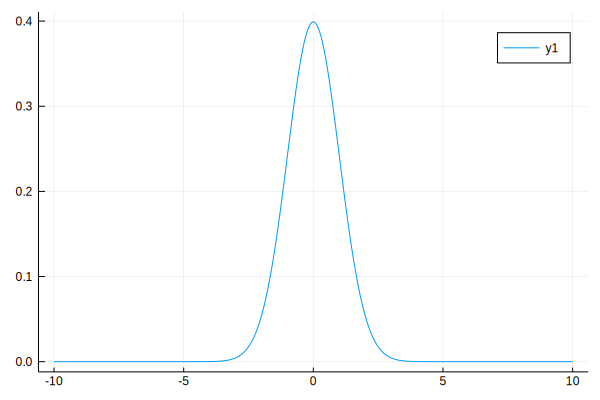

In [13]:
plot(x, y)

In [14]:
update(μ1, v1, μ2, v2) = (v2*μ1+v1*μ2)/(v2+v1), 1/(1/v2+1/v1)

update (generic function with 1 method)

In [15]:
predict(μ1, v1, μ2, v2) = μ2+μ1, v2+v1

predict (generic function with 1 method)

In [24]:
# measurements for mu and motions, U
measurements = [5., 6., 7., 9., 10.]
measurements_v = [4., 4., 4., 4., 4.]
motions = [1., 1., 2., 1., 1.]
motions_v = [2., 2., 2., 2., 2.]

# initial parameters
μ = 0.
v = 10000.

10000.0

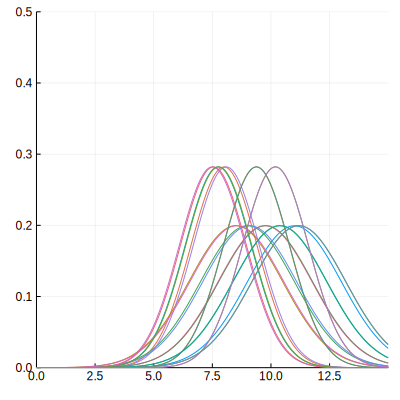

predict: 11.193353 4.000000


In [27]:
using Printf
x = collect(0:.01:15)
for n in 1:1:length(measurements)
    μ, v = update(μ, v, measurements[n], measurements_v[n])
    y = gaussian(x, μ, v);
    plot(x, y)
    plot!(xlims=(0.0, 15.0), ylims=(0.0,1.0), size = (400,400), legend = false) |> IJulia.display
    @printf("update : %f %f\n", μ, v)
    sleep(1)
    IJulia.clear_output(true)
    μ, v = predict(μ, v, motions[n], motions_v[n])
    y = gaussian(x, μ, v);
    plot(x, y)
    plot!(xlims=(0.0, 15.0), ylims=(0.0,0.5), size = (400,400), legend = false) |> IJulia.display
    @printf("predict: %f %f\n", μ, v)
    sleep(1)
    IJulia.clear_output(true)
end